In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pathlib
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
import pathlib
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import gdown

# The shared link of the file
shared_url = "https://drive.google.com/file/d/1BxHqtpflurJbH4Rgr8E1Yz4-vWd7MZBK/view?usp=drive_link"
destination = "model_aishwarya_dekhane.dogsCats.keras"

# Extract the file ID from the shared URL
file_id = shared_url.split('/d/')[1].split('/')[0]

# Construct the direct download URL
url = f"https://drive.google.com/uc?id={file_id}"

# Download the file
gdown.download(url, destination, quiet=False)
print(f"File downloaded successfully to {destination}")

Downloading...
From (original): https://drive.google.com/uc?id=1BxHqtpflurJbH4Rgr8E1Yz4-vWd7MZBK
From (redirected): https://drive.google.com/uc?id=1BxHqtpflurJbH4Rgr8E1Yz4-vWd7MZBK&confirm=t&uuid=68bc12b4-3665-4b37-81c5-df47149f8898
To: /Users/aishwaryadekhane/Desktop/My_Files/Sem-3/PRNN/HW10/model_aishwarya_dekhane.keras
100%|██████████| 39.4M/39.4M [00:00<00:00, 48.1MB/s]

File downloaded successfully to model_aishwarya_dekhane.keras


In [3]:
class DogsCats:
    CLASS_NAMES = ['cat', 'dog']
    IMAGE_SHAPE = (180, 180, 3)
    BATCH_SIZE = 32
    BASE_DIR = pathlib.Path('/Users/aishwaryadekhane/Desktop/My_Files/Sem-3/PRNN/HW10/dogs-vs-cats')
    SRC_DIR = pathlib.Path('/Users/aishwaryadekhane/Desktop/My_Files/Sem-3/PRNN/HW10/dogs-vs-cats-original/train')
    
    def __init__(self):
        self.train_dataset = None
        self.valid_dataset = None
        self.test_dataset = None
        self.model = None

    def make_dataset_folders(self, subset_name: str, start_index: int, end_index: int):
        """Create dataset folders by copying images to train/valid/test directories."""
        dest_dir = self.BASE_DIR / subset_name
        os.makedirs(dest_dir, exist_ok=True)

        for category in self.CLASS_NAMES:
            dir_path = dest_dir / category
            dir_path.mkdir(parents=True, exist_ok=True)

            files = [f'{category}.{i}.jpg' for i in range(start_index, end_index)]
            for i, file_name in enumerate(files):
                src_path = self.SRC_DIR / file_name
                dst_path = dir_path / file_name

                if src_path.exists():
                    shutil.copyfile(src=src_path, dst=dst_path)
                    if i % 100 == 0:
                        print(f'Copied: {src_path} -> {dst_path}')
                else:
                    print(f'Warning: Source file {src_path} does not exist.')

    def _make_dataset(self, subset_name: str) -> tf.data.Dataset:
        """Create a dataset from a directory."""
        subset_dir = str(self.BASE_DIR / subset_name)
        return tf.keras.utils.image_dataset_from_directory(
            subset_dir,
            image_size=self.IMAGE_SHAPE[:2],
            batch_size=self.BATCH_SIZE
        )

    def make_dataset(self):
        """Load train, validation, and test datasets."""
        self.train_dataset = self._make_dataset('train')
        self.valid_dataset = self._make_dataset('valid')
        self.test_dataset = self._make_dataset('test')

    def build_network(self, augmentation: bool = True):
        """Build and compile the CNN model."""
        model = models.Sequential()

        # Data augmentation
        if augmentation:
            model.add(layers.RandomFlip("horizontal"))
            model.add(layers.RandomRotation(0.1))

        # Base model architecture
        model.add(layers.Rescaling(1.0 / 255, input_shape=self.IMAGE_SHAPE))
        model.add(layers.Conv2D(32, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))

        # Fully connected layers
        model.add(layers.Flatten())
        model.add(layers.Dense(512, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.2))
        model.add(layers.Dense(1, activation='sigmoid'))

        # Compile the model
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Explicitly build the model
        model.build(input_shape=(None, *self.IMAGE_SHAPE))
        self.model = model

        # Print model summary
        self.model.summary()

    def train(self, model_name: str):
        """Train the model and save the best one."""
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                filepath=model_name,  # Save in native Keras format (.keras)
                save_best_only=True,
                monitor='val_accuracy',  # Monitor validation accuracy
                mode='max'  # Save when val_accuracy is maximized
            ),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)  # Early stop on validation loss
        ]

        history = self.model.fit(
            self.train_dataset,
            validation_data=self.valid_dataset,
            epochs=20,
            callbacks=callbacks
        )

        # Plot training history
        self.plot_history(history)


    def plot_history(self, history):
        """Plot training and validation metrics."""
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(len(acc))

        plt.figure(figsize=(12, 8))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, label='Training Accuracy')
        plt.plot(epochs, val_acc, label='Validation Accuracy')
        plt.legend()
        plt.title('Training and Validation Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, label='Training Loss')
        plt.plot(epochs, val_loss, label='Validation Loss')
        plt.legend()
        plt.title('Training and Validation Loss')

        plt.show()

    def load_model(self, model_name: str):
        """Load a pre-trained model."""
        self.model = tf.keras.models.load_model(model_name)
        return self.model

    def predict(self, image_file: str):
        """Predict the class of a single image."""
        img = tf.keras.utils.load_img(image_file, target_size=self.IMAGE_SHAPE[:2])
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

        predictions = self.model.predict(img_array)
        predicted_class = self.CLASS_NAMES[int(predictions[0] > 0.5)]

        plt.imshow(img)
        plt.title(f"Prediction: {predicted_class}")
        plt.axis('off')
        plt.show()


In [4]:
# Initialize the DogsCats class
dc = DogsCats()

In [5]:
# Create the dataset folders
dc.make_dataset_folders('valid', 0, 2399)
dc.make_dataset_folders('train', 2400, 11999)
dc.make_dataset_folders('test', 12000, 12499)

Copied: /Users/aishwaryadekhane/Desktop/My_Files/Sem-3/PRNN/HW10/dogs-vs-cats-original/train/cat.0.jpg -> /Users/aishwaryadekhane/Desktop/My_Files/Sem-3/PRNN/HW10/dogs-vs-cats/valid/cat/cat.0.jpg
Copied: /Users/aishwaryadekhane/Desktop/My_Files/Sem-3/PRNN/HW10/dogs-vs-cats-original/train/cat.100.jpg -> /Users/aishwaryadekhane/Desktop/My_Files/Sem-3/PRNN/HW10/dogs-vs-cats/valid/cat/cat.100.jpg
Copied: /Users/aishwaryadekhane/Desktop/My_Files/Sem-3/PRNN/HW10/dogs-vs-cats-original/train/cat.200.jpg -> /Users/aishwaryadekhane/Desktop/My_Files/Sem-3/PRNN/HW10/dogs-vs-cats/valid/cat/cat.200.jpg
Copied: /Users/aishwaryadekhane/Desktop/My_Files/Sem-3/PRNN/HW10/dogs-vs-cats-original/train/cat.300.jpg -> /Users/aishwaryadekhane/Desktop/My_Files/Sem-3/PRNN/HW10/dogs-vs-cats/valid/cat/cat.300.jpg
Copied: /Users/aishwaryadekhane/Desktop/My_Files/Sem-3/PRNN/HW10/dogs-vs-cats-original/train/cat.400.jpg -> /Users/aishwaryadekhane/Desktop/My_Files/Sem-3/PRNN/HW10/dogs-vs-cats/valid/cat/cat.400.jpg
Copi

In [6]:
# Shuffle images and prepare generators directly in the notebook
def shuffle_images_and_prepare_generators():
    """
    Shuffle images in train, validation, and test folders and prepare data generators.
    """

    def shuffle_images(directory, class_names = ['dog', 'cat']):
        """
        Shuffle images within a given directory and return relative paths.
        """
        image_list = []
        for class_name in class_names:
            class_dir = pathlib.Path(directory) / class_name
            if class_dir.exists():
                for image_path in class_dir.glob('*.jpg'):
                    # Append relative path in the format 'class_name/image_name.jpg'
                    image_list.append(f'{class_name}/{image_path.name}')
        random.shuffle(image_list)
        return image_list


    # Shuffle image paths
    train_images = shuffle_images(dc.BASE_DIR / 'train')
    valid_images = shuffle_images(dc.BASE_DIR / 'valid')
    test_images = shuffle_images(dc.BASE_DIR / 'test')

    # Data augmentation for train dataset
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Validation and test datasets
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Assign generators to class variables
    dc.train_generator = train_datagen.flow_from_directory(
        directory=str(dc.BASE_DIR / 'train'),
        target_size=dc.IMAGE_SHAPE[:2],
        batch_size=dc.BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )

    dc.valid_generator = test_datagen.flow_from_directory(
        directory=str(dc.BASE_DIR / 'valid'),
        target_size=dc.IMAGE_SHAPE[:2],
        batch_size=dc.BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )

    dc.test_generator = test_datagen.flow_from_directory(
        directory=str(dc.BASE_DIR / 'test'),
        target_size=dc.IMAGE_SHAPE[:2],
        batch_size=dc.BATCH_SIZE,
        class_mode='binary', shuffle=False
    )

In [7]:
# Shuffle images and prepare generators
shuffle_images_and_prepare_generators()

Found 19198 images belonging to 2 classes.
Found 4798 images belonging to 2 classes.
Found 998 images belonging to 2 classes.


In [8]:
dc.make_dataset()

Found 19198 files belonging to 2 classes.
Found 4798 files belonging to 2 classes.
Found 998 files belonging to 2 classes.


In [9]:
# Build the neural network
dc.build_network()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,654,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,750,529 (10.49 MB)

 Trainable params: 2,749,505 (10.49 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 178s 295ms/step - accuracy: 0.6038 - loss: 0.7045 - val_accuracy: 0.7261 - val_loss: 0.5416
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 187s 312ms/step - accuracy: 0.7240 - loss: 0.5479 - val_accuracy: 0.7491 - val_loss: 0.5144
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 197s 328ms/step - accuracy: 0.7625 - loss: 0.4993 - val_accuracy: 0.7855 - val_loss: 0.4523
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 201s 335ms/step - accuracy: 0.7863 - loss: 0.4563 - val_accuracy: 0.7693 - val_loss: 0.5016
Epoch 5/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 203s 338ms/step - accuracy: 0.8096 - loss: 0.4224 - val_accuracy: 0.8195 - val_loss: 0.4106
Epoch 6/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 209s 348ms/step - accuracy: 0.8216 - loss: 0.3986 - val_accuracy: 0.8287 - val_loss: 0.3902
Epoch 7/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 214s 357ms/step - accuracy: 0.8344 - loss: 0.3761 - val_accuracy: 0.8270 - val_loss: 0.4013
Epoch 8/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 218s 363ms/step - accuracy: 0.8474 -

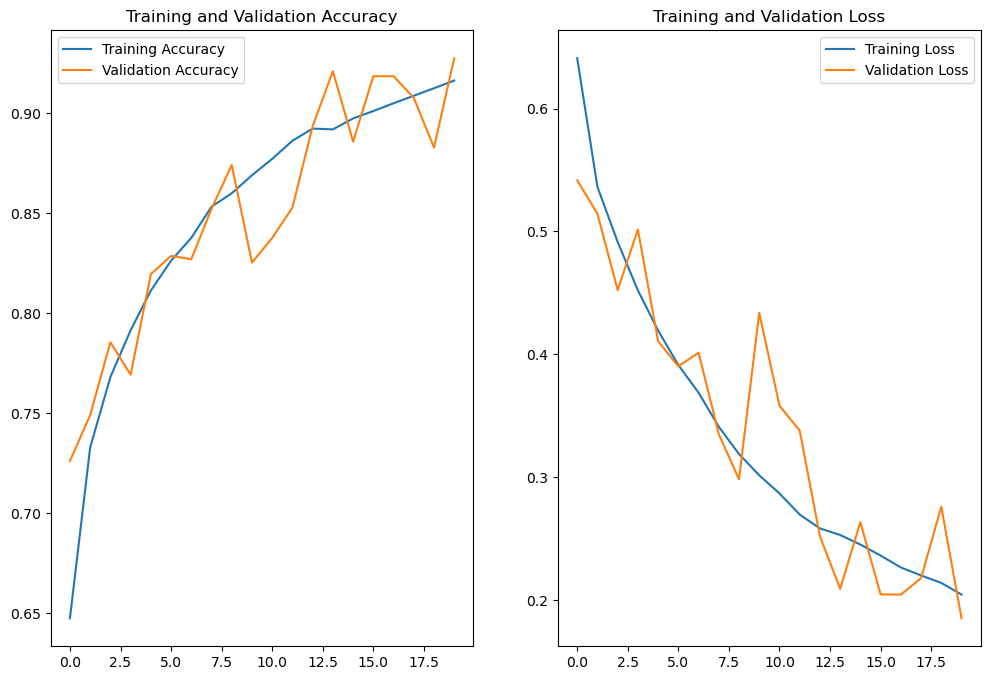

In [10]:
# Train the model
model_name = "model_aishwarya_dekhane.dogsCats.keras"
dc.train(model_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


/var/folders/tc/p09j7ll56zbbhd266ds5wqh40000gn/T/ipykernel_9404/3890973800.py:145: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = self.CLASS_NAMES[int(predictions[0] > 0.5)]


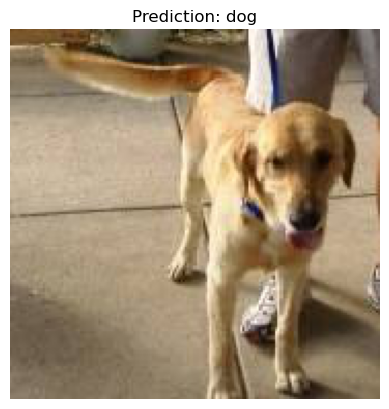

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


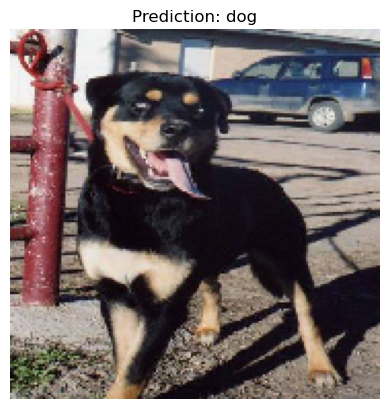

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


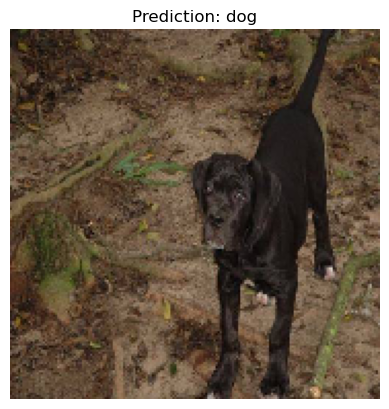

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


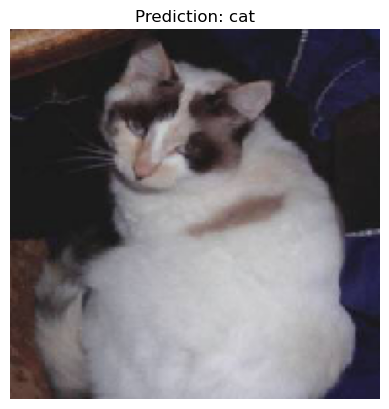

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


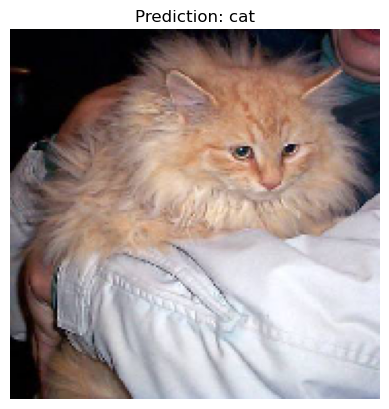

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


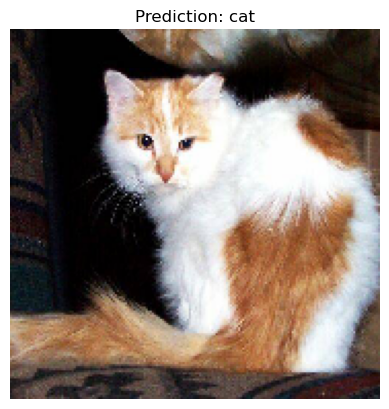

In [ ]:
dc.load_model('/Users/aishwaryadekhane/Desktop/My_Files/Sem-3/PRNN/HW10/model_aishwarya_dekhane.dogsCats.keras')

# dog
test_image = '/Users/aishwaryadekhane/Desktop/My_Files/Sem-3/PRNN/HW10/dogs-vs-cats/test/dog/dog.12062.jpg'  
dc.predict(test_image)

test_image = '/Users/aishwaryadekhane/Desktop/My_Files/Sem-3/PRNN/HW10/dogs-vs-cats/test/dog/dog.12193.jpg' 
dc.predict(test_image)

test_image = '/Users/aishwaryadekhane/Desktop/My_Files/Sem-3/PRNN/HW10/dogs-vs-cats/test/dog/dog.12351.jpg'
dc.predict(test_image)

# cat 
test_image = '/Users/aishwaryadekhane/Desktop/My_Files/Sem-3/PRNN/HW10/dogs-vs-cats/test/cat/cat.12062.jpg'
dc.predict(test_image)

test_image = '/Users/aishwaryadekhane/Desktop/My_Files/Sem-3/PRNN/HW10/dogs-vs-cats/test/cat/cat.12193.jpg'
dc.predict(test_image)

test_image = '/Users/aishwaryadekhane/Desktop/My_Files/Sem-3/PRNN/HW10/dogs-vs-cats/test/cat/cat.12351.jpg'
dc.predict(test_image)